In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## GOOGL - April 28, 2020 to April 27, 2021

In [2]:
df = pd.read_csv('../data/GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


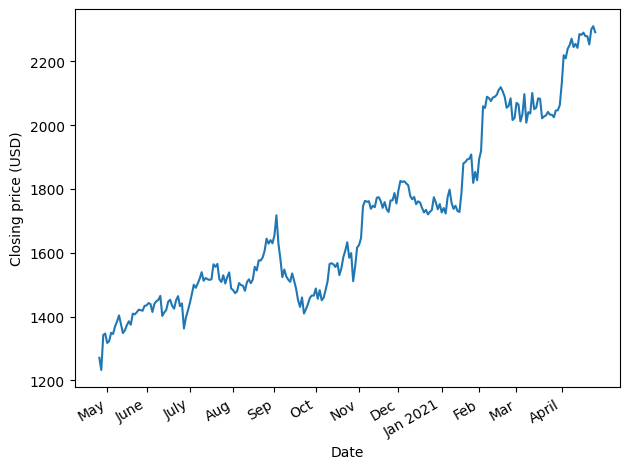

In [3]:
fig, ax = plt.subplots()

ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')

plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235], 
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2021', 'Feb', 'Mar', 'April'])

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH03_F01_peixeiro.png', dpi=300)

### 3.2.5 Is GOOGL a random walk? 

In [4]:
GOOGL_ADF_result = adfuller(df['Close'])

print(f'ADF Statistic: {GOOGL_ADF_result[0]}')
print(f'p-value: {GOOGL_ADF_result[1]}')

ADF Statistic: 0.1602504866477137
p-value: 0.9699419435913057


Note: 
- p-value is >0.05, the close price is not stationary.
- apply first order difference

In [5]:
diff_close = np.diff(df['Close'], n=1)

In [6]:
# check for stationary. p-value is less than 0.05. Yes, it is stationary.
GOOGL_diff_ADF_result = adfuller(diff_close)

print(f'ADF Statistic: {GOOGL_diff_ADF_result[0]}')
print(f'p-value: {GOOGL_diff_ADF_result[1]}')

ADF Statistic: -5.3034397042952195
p-value: 5.386530961454948e-06


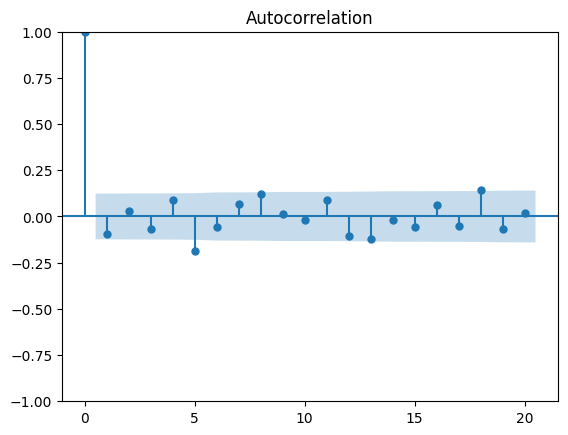

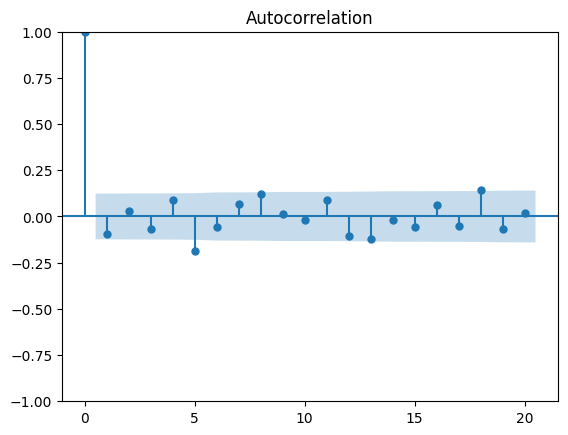

In [7]:
#check for autocorrealtion. There is no autocorrelation.

plot_acf(diff_close, lags=20)

## 3.3 Forecasting a random walk

Predicting a random change is impossible, unless we predict a random value ourselves, which is not ideal. In this case, we can only use naive forecasting methods, or baselines, which we covered previously. Since the values change randomly, no statistical learning model can be applied. Instead, we can only reasonably predict the historical mean, or the last value.

Depending on the use case, your forecasting horizon will vary. Ideally, when dealing with a random walk, you will only forecast the next timestep. However, you may be required to forecast many timesteps into the future. Let’s look at how to tackle each of these situations.

## 3.4.2 Forecast the daily closing price of GOOGL 

In [8]:
df = pd.read_csv('../data/GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


In [9]:
# Keep the last five days to test your forecasts

googl_train = df[['Date','Close']][:-5]
googl_test = df[['Date','Close']][-5:]

In [10]:
googl_test

,Date,Close
248,2021-04-21,2278.350098
249,2021-04-22,2252.520020
250,2021-04-23,2299.929932
251,2021-04-26,2309.929932
252,2021-04-27,2290.979980


In [18]:
# Forecast the historical mean
mean = np.mean(googl_train['Close'])
googl_test.loc[:, 'pred_mean'] = mean

# Forecast using the last knwon value
last_value = googl_train['Close'].iloc[-1]
googl_test.loc[:, 'pred_last'] = last_value

# Forecast using the drift
deltaX = len(googl_train)    # The deltaX is basically the length of the training set
deltaY = last_value - googl_train['Close'].iloc[0]    # Remember to subtract the initial value of the training set

drift = deltaY / deltaX

x_vals = np.arange(248, 253, 1)

pred_drift = drift * x_vals + googl_train['Close'].iloc[0]    #A Add the initial value back in the predictions

googl_test.loc[:, 'pred_drift'] = pred_drift

googl_test

,Date,Close,pred_mean,pred_last,pred_drift
248,2021-04-21,2278.350098,1689.993184,2279.01001,2279.010010
249,2021-04-22,2252.520020,1689.993184,2279.01001,2283.075131
250,2021-04-23,2299.929932,1689.993184,2279.01001,2287.140252
251,2021-04-26,2309.929932,1689.993184,2279.01001,2291.205373
252,2021-04-27,2290.979980,1689.993184,2279.01001,2295.270494


In [19]:
from sklearn.metrics import mean_squared_error

googl_mse_mean = mean_squared_error(googl_test['Close'], googl_test['pred_mean'])
googl_mse_last = mean_squared_error(googl_test['Close'], googl_test['pred_last'])
googl_mse_drift = mean_squared_error(googl_test['Close'], googl_test['pred_drift'])

print(googl_mse_mean, googl_mse_last, googl_mse_drift)

356025.96701539395 447.82398976418415 293.3287644069853


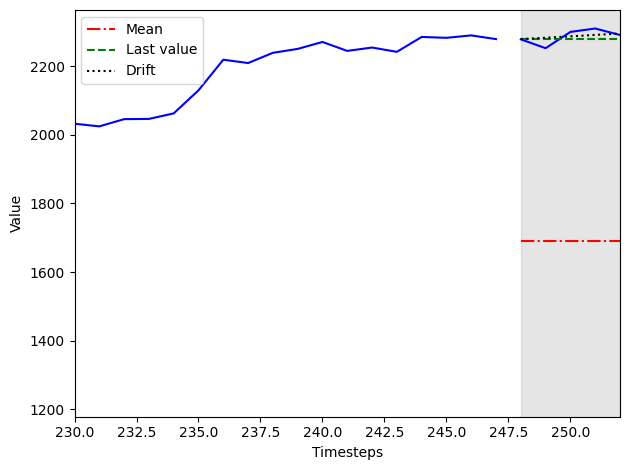

In [20]:
fig, ax = plt.subplots()

ax.plot(googl_train['Close'], 'b-')
ax.plot(googl_test['Close'], 'b-')
ax.plot(googl_test['pred_mean'], 'r-.', label='Mean')
ax.plot(googl_test['pred_last'], 'g--', label='Last value')
ax.plot(googl_test['pred_drift'], 'k:', label='Drift')

ax.axvspan(248, 252, color='#808080', alpha=0.2)
ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(230, 252)
plt.tight_layout()

In [21]:
# Forecast the next timestep
df_shift = df.shift(periods=1)

mse_one_step = mean_squared_error(googl_test['Close'], df_shift['Close'].iloc[248:])

mse_one_step

674.8857699967758

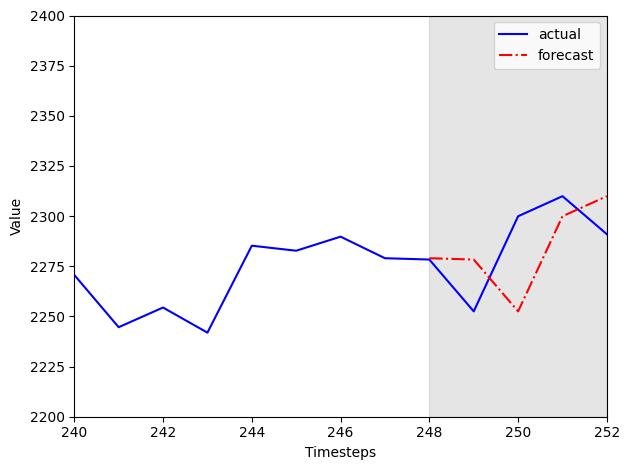

In [22]:
fig, ax = plt.subplots()

ax.plot(df['Close'], 'b-', label='actual')
ax.plot(df_shift['Close'].iloc[248:], 'r-.', label='forecast')

ax.axvspan(248, 252, color='#808080', alpha=0.2)

ax.legend(loc='best')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.xlim(240, 252)
plt.ylim(2200, 2400)
plt.tight_layout()